<a href="https://colab.research.google.com/github/lgvaz/faststyle/blob/master/examples/hats_on_cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !nvidia-smi

Thu Mar 12 18:24:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
# !pip install -q fastai2

     |████████████████████████████████| 184kB 3.4MB/s 


In [0]:
from fastai2.basics import *
from fastai2.vision.all import *

In [4]:
!gdown https://drive.google.com/uc?id=1WcxHwzvhFuzwWPEwiNr4prozGIWQtOVu
!unzip -q cats.zip

Downloading...
From: https://drive.google.com/uc?id=1WcxHwzvhFuzwWPEwiNr4prozGIWQtOVu
To: /content/cats.zip
2.17GB [00:28, 75.5MB/s]


In [0]:
source = Path('cats')

In [0]:
fns = get_image_files(source)
fn = fns[0]

In [0]:
def get_y_fn(fn): return fn.with_suffix(fn.suffix+'.cat')
def get_kpts(fn): return np.genfromtxt(fn)[1:].reshape(-1,2)
def get_y(fn):    return get_kpts(get_y_fn(fn))

In [0]:
class CatPoint(TensorPoint):
  @property
  def eyes(self): return (self[0], self[1])
  @property
  def ears(self): return (self[3:6], self[6:9])
  @property
  def leye(self): return min(self.eyes, key=itemgetter(0))
  @property
  def reye(self): return max(self.eyes, key=itemgetter(0))
  @property
  def mouth(self): return self[2]
  @property
  def lear(self): return min(self.ears, key=lambda x: x[0][0])
  @property
  def rear(self): return max(self.ears, key=lambda x: x[0][0])
  @property
  def flip(self): return bool(self.eyes[0][0] > self.eyes[1][0])
  
  # this fails if you dont override
  @classmethod
  def create(cls, t, img_size=None)->None:
    "Convert an array or a list of points `t` to a `Tensor`"
    return cls(tensor(t).view(-1, 2).float(), img_size=img_size)

In [0]:
def get_head_pnts(pt):
  left,top = pt.lear.min(axis=0)[0].numpy()
  right,_  = pt.rear.max(axis=0)[0].numpy()
  bottom = min(pt.leye[1], pt.reye[1])
  pnts = np.array([left,top,right,bottom], dtype=int)
  return pnts

In [0]:
def get_angle(pt):
  x,y = pt.rear[-1] - pt.lear[0] 
  slope = np.divide(y,x, where=x!=0)
  return -np.arctan(slope) * (180/np.pi) + (180 if pt.flip else 0)

In [0]:
def get_size(pnts):
  return pnts[2:]-pnts[:2]

In [0]:
def unscale_pnts(y, sz): return CatPoint((y+1) * tensor(sz).float()/2, img_size=sz)

In [0]:
hat = PILImage.create('hats/hat1.png', mode='RGBA')
def get_hat_pt(pt):
  head = get_head_pnts(pt)
  w,_ = get_size(head)
  # Substitute top of head to maintain hat ratio
  h = w/np.divide(*hat.size)
  if pt.flip: head[-1] = head[1] + h
  else:       head[1] = head[-1] - h
  return head

In [0]:
def put_hat(im, cat_pt, hat_pt, hat):
  im = im.copy()
  hat = hat.resize(get_size(hat_pt)).rotate(get_angle(cat_pt))
  im.paste(hat, hat_pt, hat)
  return im

In [0]:
def get_y2(fn):
  cat_pt = CatPoint.create(get_y(fn))
  hat_pt = get_hat_pt(cat_pt)
  im = PILImage.create(fn)
  im = put_hat(im, cat_pt, hat_pt, hat)
  return PILImage(im)

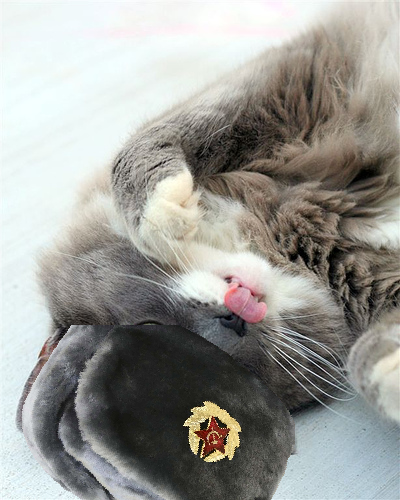

In [44]:
# fn = fns[1]
fn = Path('cats/CAT_02/00000510_005.jpg')
get_y2(fn)

In [0]:
dblock = DataBlock((ImageBlock, ImageBlock), get_y=get_y2, get_items=get_image_files, splitter=RandomSplitter(.1),
                   item_tfms=[Resize(128)], batch_tfms=[Normalize.from_stats(*imagenet_stats)])

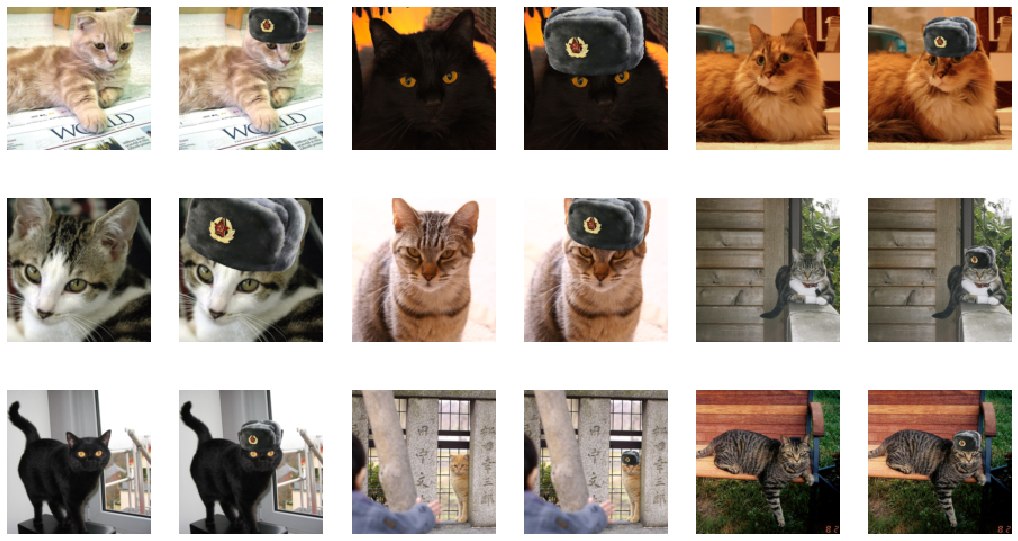

In [55]:
dls = dblock.dataloaders(source); dls.c = 3
dls.show_batch()

In [0]:
learn = unet_learner(dls=dls, arch=resnet34, loss_func=MSELossFlat())

(0.0013182567432522773, 0.00019054606673307717)

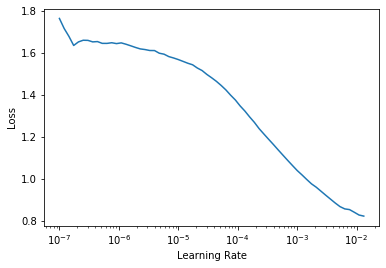

In [57]:
learn.lr_find()

In [62]:
learn.fit_one_cycle(3, 1e-3, pct_start=.72)

epoch,train_loss,valid_loss,time
0,0.098357,0.094901,05:38
1,0.080962,0.078318,05:19
2,0.060876,0.058651,05:14


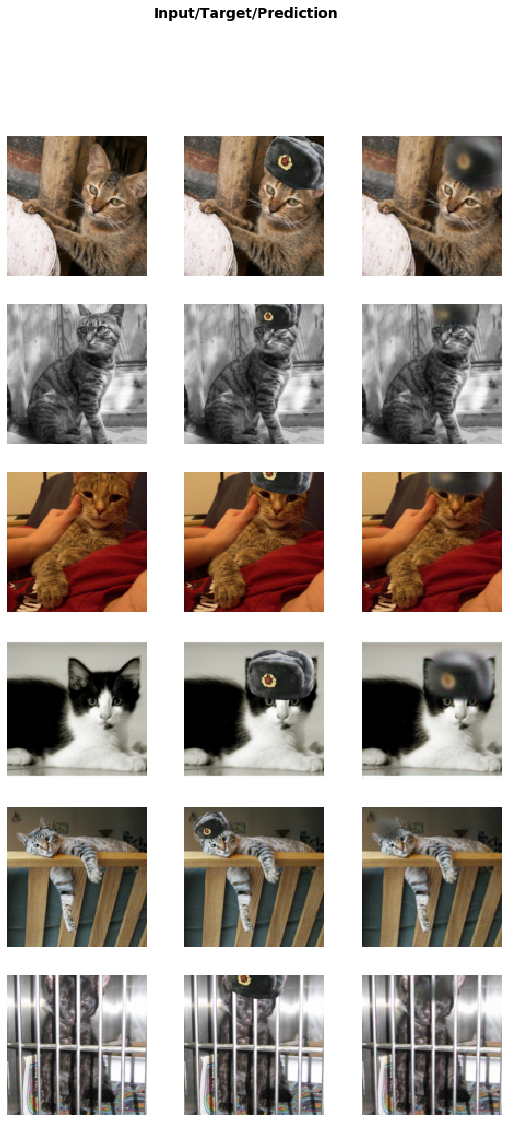

In [63]:
learn.show_results()